1.872875504813765e-12 1.9294901328637138e-10 1.9325038270016688e-10


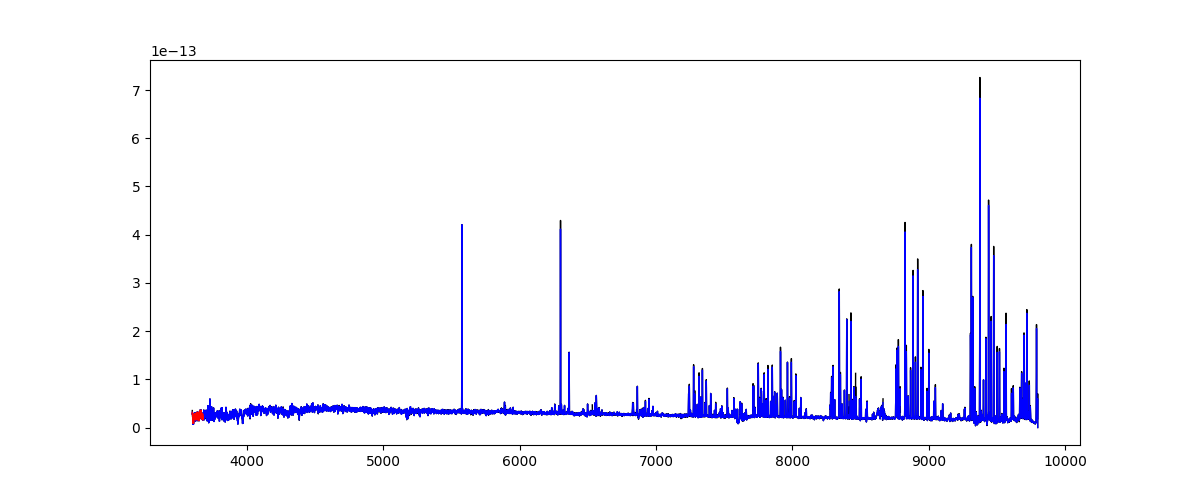

In [17]:
import numpy
import lvmdrp.core.resample as resample
import matplotlib.pyplot as plt
from scipy import interpolate
from astropy.io import fits

def interpolate_mask(x, y, mask, kind="linear", fill_value=0):
    """
    :param x, y: numpy arrays, samples and values
    :param mask: boolean mask, True for masked values
    :param method: interpolation method, one of linear, nearest,
    nearest-up, zero, slinear, quadratic, cubic, previous, or next.
    :param fill_value: which value to use for filling up data outside the
        convex hull of known pixel values.
        Default is 0, Has no effect for 'nearest'.
    :return: the image with missing values interpolated
    """
    if not numpy.any(mask):
        return y
    known_x, known_v = x[~mask], y[~mask]
    missing_x = x[mask]
    missing_idx = numpy.where(mask)

    f = interpolate.interp1d(known_x, known_v, kind=kind, fill_value=fill_value, bounds_error=False)
    yy = y.copy()
    yy[missing_idx] = f(missing_x)

    return yy



with fits.open("/Users/droryn/work/LVM/data/sas/sdsswork/lvm/spectro/redux/1.1.0dev/1039XX/1039949/60356/lvmCFrame-00012618.fits") as hdu:
    s1 = hdu['FLUX'].data
    d1 = hdu['IVAR'].data
    w1 = hdu['WAVE'].data

f = 1022
s1 = s1[f,:]
d1 = d1[f,:]

%matplotlib widget
# vega = numpy.genfromtxt('/Users/droryn/prog/sedfit/bc/A0V_KUR.SED', skip_header=1, usecols=(0,1))
# w1 = vega[:,0]
# lvm = numpy.where((w1>=3700)*(w1<9800))
# w1 = w1[lvm]
# s = vega[:,1][lvm]/1e8
fig = plt.figure(figsize=(12,5))
plt.plot(w1, s1, color='black', linewidth=1)

w2 = numpy.logspace(numpy.log10(w1[1]), numpy.log10(w1[-1]), len(w1), endpoint=True)
# specutils
s2 = resample.rebin_spectra(w2, w1, s1, spec_errs=None, fill=0)
plt.plot(w2, s2, color='blue', linewidth=1)
#%timeit rebin_spectra(w2, w1, s, spec_errs=None, fill=0)

# DESI

s1p = interpolate_mask(w1, s1, ~numpy.isfinite(s1))
s3 = resample.resample_flux(w2, w1, s1p, ivar=None)
#%timeit resample.resample_flux(w2, w1, s1)
plt.plot(w2, s3, color='red', linewidth=1)
print(numpy.nansum(s3*numpy.gradient(w2)), numpy.nansum(s2*numpy.gradient(w2)), numpy.nansum(s1*numpy.gradient(w1)))
#plt.plot(w2,s2, 'r.')

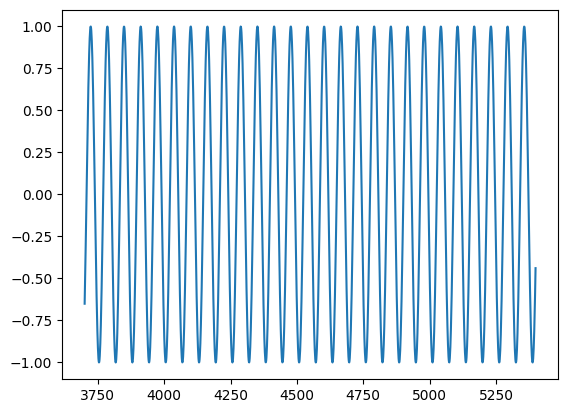

In [6]:
import matplotlib.pyplot as plt
w1 = numpy.arange(3700,5400,1.0, dtype=numpy.float32)
s = numpy.sin(w1*1e-1)
w2 = w1+1.2
s2 = congrid(s, )

392 µs ± 8.15 µs per loop (mean ± std. dev. of 7 runs, 1,000 loops each)


/var/folders/31/fxk1ql6s5bx7q3kh6kwpf8v8c5vp86/T/ipykernel_2151/1975593494.py:203: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if e2[ii+1] < emax : emax = e2[ii+1]
/var/folders/31/fxk1ql6s5bx7q3kh6kwpf8v8c5vp86/T/ipykernel_2151/1975593494.py:211: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if e2[ii+1] > emax :


21.9 ms ± 532 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)
9.655039 9.661622770535601 10.10591553149672


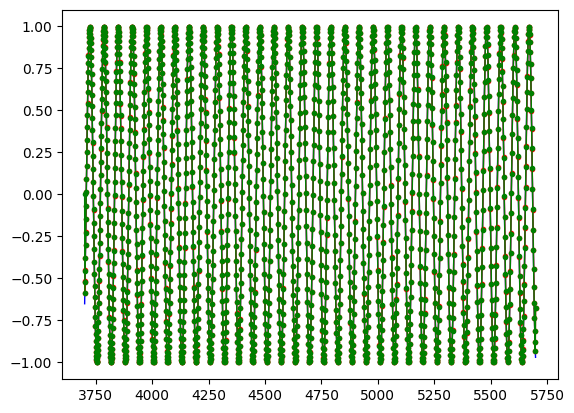

In [1]:
import numpy as np

import matplotlib.pyplot as plt
w1 = np.arange(3700,5700, 0.5, dtype=np.float32)
s = np.sin(w1*1e-1)
w2 = np.logspace(np.log10(w1[0]), np.log10(w1[-1]), len(w1)//2)
s2 = resample_flux(w2, w1, s)
%timeit resample_flux(w2, w1, s)
s3 = resample_project(w1, s, w2)
%timeit resample_project(w1, s, w2)

plt.plot(w1, s, 'b-', linewidth=1)
plt.plot(w2, s2, 'r-', linewidth=1)
plt.plot(w2, s2, 'r.')
plt.plot(w2, s3, 'g-', linewidth=1)
plt.plot(w2, s3, 'g.')

print(np.sum(np.gradient(w1)*s), np.sum(np.gradient(w2)*s2), np.sum(np.gradient(w2)*s3))